In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from tqdm import tqdm
import re
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import numpy as np
import gensim
import numpy as np
from sklearn.model_selection import train_test_split

In [3]:
df = pd.read_csv('data_m.csv', index_col=0)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3558 entries, 0 to 3557
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   VAP     3558 non-null   int64 
 1   TEXT    3558 non-null   object
dtypes: int64(1), object(1)
memory usage: 83.4+ KB


<Axes: ylabel='count'>

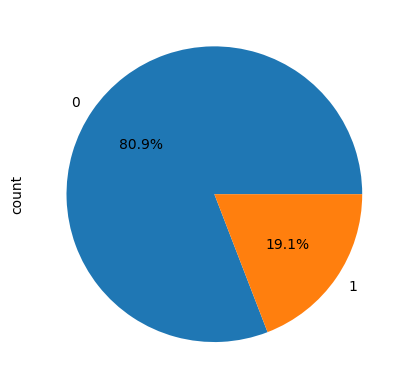

In [5]:
# pie chart of Label
df['VAP'].value_counts().plot.pie(autopct='%1.1f%%')


In [6]:
def parse_medical_records(text):

    pattern = r'(\[\*\*\d{4}-\d{1,2}-\d{1,2}\*\*\]\s*\d{1,2}:\d{2}\s*(AM|PM).*?(?=\[\*\*\d{4}-\d{1,2}-\d{1,2}\*\*\]\s*\d{1,2}:\d{2}\s*(AM|PM)|$))'
    reports = re.findall(pattern, text, re.DOTALL)

    extracted_reports = []
    seen_reports = set()

    for report_tuple in reports:
        report = report_tuple[0]  # Extract the report from the tuple

        # Extracting various pieces of information using regular expressions
        report_id = re.search(r'\[\*\*(\d{4}-\d{1,2}-\d{1,2})\*\*\]', report)
        type_of_exam = re.search(r'CHEST \((.*?)\)', report)
        clip_number = re.search(r'Clip Number \(Radiology\) (\d+)', report)
        reason_for_exam = re.search(r'Reason: (.+)', report)
        admitting_diagnosis = re.search(r'Admitting Diagnosis: (.+)', report)
        medical_condition = re.search(r'MEDICAL CONDITION:\n\s+(.+)', report)
        final_report = re.search(r'FINAL REPORT\n\s+(.+)', report, re.DOTALL)

        # Building the report string
        report_string = ""
        if report_id:
            report_string += f"Report ID: {report_id.group(1)}\n"
        if type_of_exam:
            report_string += f"Type of Exam: {type_of_exam.group(1)}\n"
        if clip_number:
            report_string += f"Clip Number: {clip_number.group(1)}\n"
        if reason_for_exam:
            report_string += f"Reason for Exam: {reason_for_exam.group(1)}\n"
        if admitting_diagnosis:
            report_string += f"Admitting Diagnosis: {admitting_diagnosis.group(1)}\n"
        if medical_condition:
            report_string += f"Medical Condition: {medical_condition.group(1)}\n"
        if final_report:
            report_string += f"Final Report: {final_report.group(1)}\n"

        report_string = report_string.strip()
        
        # Add report to the extracted reports if it's not a duplicate
        if report_string not in seen_reports:
            extracted_reports.append(report_string)
            seen_reports.add(report_string)
        
    # concatenate all the reports into a single string
    return "\n\n".join(extracted_reports)

# apply the function to the TEXT column
tqdm.pandas()
df["Cleaned_TEXT"] = df["TEXT"].progress_apply(parse_medical_records)

100%|██████████| 3558/3558 [00:13<00:00, 257.67it/s]


In [7]:
# remove rows with empty TEXT
df = df[df["Cleaned_TEXT"] != ""]

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3304 entries, 0 to 3557
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   VAP           3304 non-null   int64 
 1   TEXT          3304 non-null   object
 2   Cleaned_TEXT  3304 non-null   object
dtypes: int64(1), object(2)
memory usage: 103.2+ KB


In [10]:
# import gensim.downloader as api
# import numpy as np
# import pandas as pd
# from tqdm import tqdm

# # Load a pre-trained word2vec model (this is just an example model)
# embedder = api.load("glove-wiki-gigaword-100")  # This model has 100-dimensional embeddings

# def get_word_embeddings(sample):
#     words = sample.split()
#     embeddings = []
#     for word in words:
#         if word in embedder.key_to_index:
#             embeddings.append(embedder[word])
#         else:
#             continue
#     return np.array(embeddings)
import gensim
import numpy as np

# Load your pre-trained word2vec model
embedder = gensim.models.KeyedVectors.load_word2vec_format("pubmed_mesh_test.bin", binary=True)

def get_word_embeddings(sample):
    words = sample.split()
    # Create a list to hold embeddings
    embeddings = []
    for word in words:
        if word in embedder.key_to_index:
            # Add the word embedding to the list
            embeddings.append(embedder[word])
        else:
            continue
    return np.array(embeddings)

tqdm.pandas()
df["EMBEDDINGS"] = df["Cleaned_TEXT"].progress_apply(get_word_embeddings)

100%|██████████| 3304/3304 [00:03<00:00, 1019.22it/s]


In [11]:
# remove rows with empty EMBEDDINGS
df = df[df["EMBEDDINGS"].map(len) > 0]

In [12]:
df["EMBEDDINGS"].apply(lambda x: x.shape).value_counts()

EMBEDDINGS
(121, 200)     14
(302, 200)     13
(142, 200)     12
(62, 200)      12
(54, 200)      10
               ..
(1347, 200)     1
(1806, 200)     1
(1926, 200)     1
(3572, 200)     1
(863, 200)      1
Name: count, Length: 1505, dtype: int64

In [ ]:
# pie chart of Label
df['VAP'].value_counts().plot.pie(autopct='%1.1f%%')

In [13]:
from torch.nn.utils.rnn import pad_sequence

class MedicalDataset(Dataset):
    def __init__(self, embeddings, labels):
        self.embeddings = embeddings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.embeddings[idx], self.labels[idx]

    def collate_fn(batch):
        # Separate the embeddings and labels
        embeddings, labels = zip(*batch)

        # Convert embeddings from numpy arrays to torch tensors
        embeddings_tensor = [torch.tensor(e, dtype=torch.float32) for e in embeddings]

        # Pad the embeddings to the same length
        embeddings_padded = pad_sequence(embeddings_tensor, batch_first=True, padding_value=0)
        labels_tensor = torch.tensor(labels, dtype=torch.long)

        return embeddings_padded, labels_tensor

    
class Transformer(nn.Module):
    def __init__(self, embedding_size, num_heads, num_classes, dim_feedforward=2048, num_layers=4, num_conv_layers=2, conv_kernel_size=3):
        super(Transformer, self).__init__()

        # Convolutional layers
        self.conv_layers = nn.ModuleList([nn.Conv1d(in_channels=embedding_size, 
                                                    out_channels=embedding_size, 
                                                    kernel_size=conv_kernel_size, 
                                                    padding=conv_kernel_size // 2) for _ in range(num_conv_layers)])
        
        # Transformer encoder layers
        self.transformer_encoder_layer = nn.TransformerEncoderLayer(
            d_model=embedding_size, 
            nhead=num_heads, 
            dim_feedforward=dim_feedforward
        )
        self.transformer_encoder = nn.TransformerEncoder(self.transformer_encoder_layer, num_layers=num_layers)
        
        # Additional fully connected layers
        self.fc1 = nn.Linear(embedding_size, embedding_size * 2)
        self.fc2 = nn.Linear(embedding_size * 2, embedding_size)

        # Final classifier layer
        self.classifier = nn.Linear(embedding_size, num_classes)

    def forward(self, x):
        # Transpose x to match the input requirement of conv1d: [batch_size, channels, sequence_length]
        x = x.transpose(1, 2)  # Transpose the dimensions to [batch_size, embedding_size, sequence_length]

        # Pass through convolutional layers
        for conv in self.conv_layers:
            x = F.relu(conv(x))

        # Transpose back to [batch_size, sequence_length, embedding_size] for the transformer encoder
        x = x.transpose(1, 2)

        # Pass through transformer encoder layers
        x = self.transformer_encoder(x)
        x = x.mean(dim=1)  # Aggregate over the sequence dimension

        # Pass through fully connected layers
        x = F.relu(self.fc1(x))
        x = F.dropout(x, 0.2)  # Dropout for regularization
        x = F.relu(self.fc2(x))

        # Classification
        return self.classifier(x)


In [16]:
# Convert embeddings and labels to a suitable format
embeddings = np.array(df['EMBEDDINGS'].values)
labels = df['VAP'].values

# Split data into training and validation sets (80-20 split)
embeddings_train, embeddings_val, labels_train, labels_val = train_test_split(
    embeddings, labels, test_size=0.2, random_state=42)

# Create custom datasets for training and validation
train_dataset = MedicalDataset(embeddings_train, labels_train)
val_dataset = MedicalDataset(embeddings_val, labels_val)

batch_size = 2

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=MedicalDataset.collate_fn)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=MedicalDataset.collate_fn)

In [17]:
embedding_size = embedder.vector_size  # Size of a single word embedding
num_heads = 4  # Number of attention heads
num_classes = 2  # Number of output classes
num_layers = 4  # Number of transformer layers
num_conv_layers = 2  # Number of convolutional layers
model = Transformer(embedding_size, num_heads, num_classes, num_layers=num_layers, num_conv_layers=num_conv_layers)

# Use GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

learning_rate = 0.01  
weight_decay = 0.001  
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

from sklearn.utils.class_weight import compute_class_weight

# 'labels' is an array of all the labels in your training dataset
class_weights = compute_class_weight('balanced', classes=np.unique(labels_train), y=labels_train)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)


# Training loop
model.train()  # Set the model to training mode
for epoch in range(20):  # number of epochs
    total_loss = 0
    for embeddings_batch, labels_batch in train_loader:
        # Send data to device (GPU or CPU)
        embeddings_batch = embeddings_batch.to(device).float()
        labels_batch = labels_batch.to(device).long()

        # Forward pass
        outputs = model(embeddings_batch)

        # Compute weighted loss
        loss = F.cross_entropy(outputs, labels_batch, weight=class_weights)

        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch}, Average Training Loss: {avg_loss}")

    # Validation step
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    with torch.no_grad():  # No need to track gradients during validation
        for embeddings_batch, labels_batch in val_loader:
            embeddings_batch = torch.tensor(embeddings_batch).to(device).float()
            labels_batch = torch.tensor(labels_batch).to(device).long()

            outputs = model(embeddings_batch)
            _, predicted = torch.max(outputs.data, 1)
            total += labels_batch.size(0)
            correct += (predicted == labels_batch).sum().item()

    accuracy = correct / total
    print(f"Validation Accuracy: {accuracy}")

Epoch 0, Average Training Loss: 0.6864581836455158
Validation Accuracy: 0.832572298325723
Epoch 1, Average Training Loss: 0.6120394558576325
Validation Accuracy: 0.832572298325723
Epoch 2, Average Training Loss: 0.6606506244418626
Validation Accuracy: 0.832572298325723
Epoch 3, Average Training Loss: 0.6106339289354589
Validation Accuracy: 0.832572298325723


KeyboardInterrupt: 